In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy as sc
import h5py
import xarray as xr
import multiprocessing as mp
import os
import gstools as gs
import torch

# Generate Gaussian process regression

In [48]:
# Set parameters
p = 256
n_sim = 2200
x = np.linspace(0,20,p)

# Set seed generator
seed = gs.random.MasterRNG(10)
model = gs.Matern(spatial_dim=1, nu = 1, var = 1, len_scale=2)
srf = gs.SRF(model)
noise = np.array([srf.structured(x, seed = seed()) for i in range(n_sim)])
y = 2*np.sin(2*x) + noise 


#np.save("data/grf_data.npy", y)

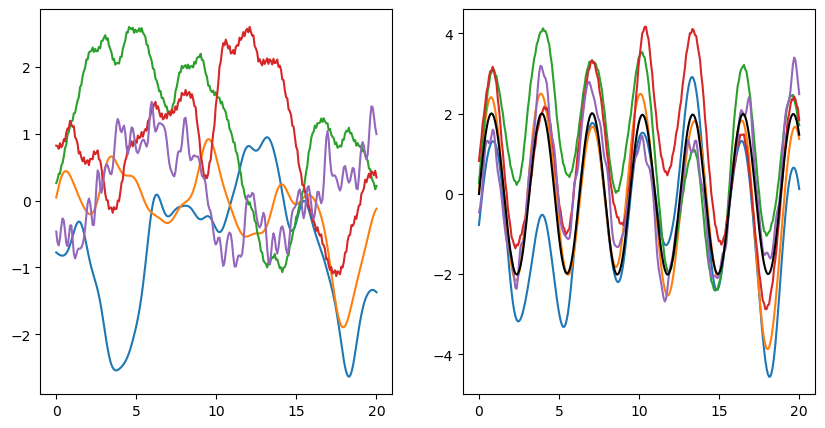

In [49]:
# plot 5 samples
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in np.random.choice(range(n_sim), 5):
    axs[0].plot(x, noise[i])
    axs[1].plot(x, y[i])
axs[1].plot(x, y.mean(axis = 0), color = "black")

<Axes: >

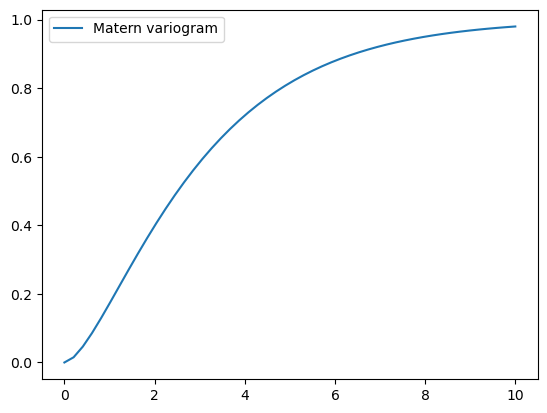

In [50]:
model.plot(x_max=10)

# Generate spatio-temporal random Gaussian field

In [288]:
# Set coordinates and sizes
dim = 64
time_dim = 10
length = 10.0
time_length = 10.0
x = y = np.linspace(0, length, dim)
t = np.linspace(0, time_length, time_dim)

# Set seed generator
seed = gs.random.MasterRNG(20170519)

In [289]:
# Define covariance model
scales = [2,2,1]
nu = 4
model = gs.Matern(
    temporal=True, spatial_dim=2, var=1, nu = nu, len_scale = scales
)
# create a spatial random field instance
srf = gs.SRF(model)
pos, time = [x, y], [t]
# the Gaussian random field
srf.set_pos(pos + time, "structured")

In [290]:
# Generate random fields
n_sim = 50

for i in range(20):
    fields = np.zeros((n_sim, dim, dim, time_dim))
    for sim in range(n_sim):
        fields[sim] = srf(seed = seed())

    np.save(f"data/grf/grf_{i+1}.npy", fields)
    print(f"Finished iteration {i+1}")

Finished iteration 1
Finished iteration 2
Finished iteration 3
Finished iteration 4
Finished iteration 5
Finished iteration 6
Finished iteration 7
Finished iteration 8
Finished iteration 9
Finished iteration 10
Finished iteration 11
Finished iteration 12
Finished iteration 13
Finished iteration 14
Finished iteration 15
Finished iteration 16
Finished iteration 17
Finished iteration 18
Finished iteration 19
Finished iteration 20


In [4]:
full_results = np.concatenate([np.load(f"data/grf/{name}") for name in os.listdir("data/grf/")], axis = 0)
full_results = np.moveaxis(full_results, -1, 1)
np.save("data/grf_data.npy", full_results)

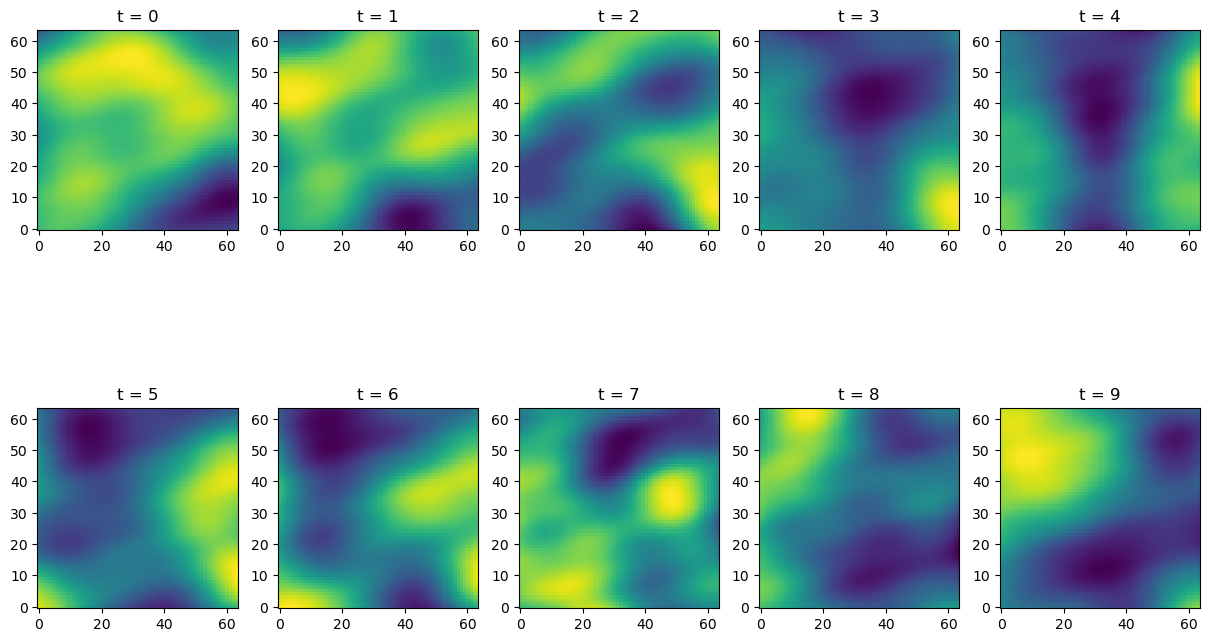

In [294]:
sample = 20
fig, axs = plt.subplots(2, 5, figsize=(15, 9))
for i, ax in enumerate(axs.flat):
    ax.imshow(fields[sample,:, :, i], origin="lower")
    ax.set_title(f"t = {i}")

# Estimate variogram

In [284]:
field_list = [fields[sample,:,:,0] for sample in range(n_sim)]

In [285]:
bins = np.linspace(0,10,30)
bin_center, gamma = gs.vario_estimate(pos, field_list, bins, mesh_type="structured")

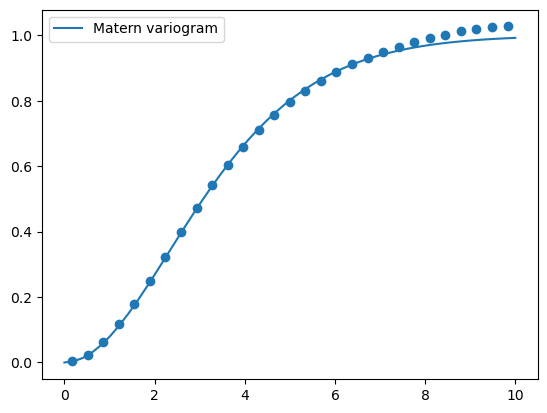

In [286]:
ax = model.plot(x_max=10)
ax.scatter(bin_center, gamma)